# Predicting heart rate during excercise with LSTM

Training an LSTM model to predict heart rate in n seconds in future based on the sensor measurements over the past 60 seconds. The data is collected from Garmin Fenix 6s during running excercises, performed by the author, in diffrent environment and conditions. The fit files data was converted into csv files with fitdecode library https://github.com/polyvertex/fitdecode. Fit-files format is used at least by Garmin and Suunto devices.

Some of the useful inputs available for diffrent activities like cycling or running include:
- heart rate
- cadence
- speed
- altitude
- grade 
- power
- distance

In [3]:
# load libraries
import os, glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# location of the fit files
fit_path = "C:/Users/krish/Documents/RK/PROJECTS_RK/DevaHrdaya - देवहृदय/fit_file_csv"
fit_test_path = "C:/Users/krish/Documents/RK/PROJECTS_RK/DevaHrdaya - देवहृदय/fit_file_test_csv"
graph_path = "C:/Users/krish/Downloads/athlete_hr_predict-master/graphs"
os.chdir(fit_path)


In [4]:
# add calculated altitude difference column, and 5sec moving average column. Remove geographical coordinates for privacy.
fit_files = glob.glob("*.csv")
for file in fit_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')
    df['alt_difference'] = df['enhanced_altitude'] - df['enhanced_altitude'].shift(1)
    df['rolling_ave_alt'] = df['alt_difference'].rolling(window=5).mean()
    df = df.bfill()
    df = df.drop(['position_lat','position_long'], axis=1, errors='ignore')
    df.to_csv(fit_path+'/'+file)


In [5]:
# set parameters, file names

#select the features for EDA graphs:
eda_model_features =  ["heart_rate", "enhanced_speed","rolling_ave_alt", "cadence", "distance", "enhanced_altitude"] #  cadence, enhanced_altitude, distance, heart_rate, enhanced_speed, rolling_ave_alt

#select the predictors for the model:
model_features =  ["heart_rate", "enhanced_speed","rolling_ave_alt","cadence"] #  cadence, altitude, distance, heart_rate, enhanced_speed, rolling_ave_alt
batch_size = 250 # training batch size for the LSTM
epochs = 180 # maximum number of epochs - autostop will work on per file basis
learning_rate = 0.001
decay_rate = 0.001
n_X = 120 # number of timesteps for training
n_y = 22 # number of timesteps in future for prediction
step = 1 # step size of predictors for model training

sequence_length = int(n_X/step)
n_fit_files_test_set = 10 # number of files for validation dataset (only 1 validation file supported at the moment)

# select the training files and the validation files 
train_files = glob.glob(fit_path+"/*.csv")[0:-n_fit_files_test_set]
valid_files = glob.glob(fit_path+"/*.csv")[-n_fit_files_test_set:]
test_files = glob.glob(fit_test_path+"/*.csv")


In [6]:
# calculate the data normalisation parameters from all training data

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    #return (data - data_mean) / data_std, data_mean, data_std
    return data_mean, data_std

li = []

for file in train_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df_mean, df_std = normalize(df)

def denormalize_hr(data):
    return data*df_std[0]+df_mean[0] 

## Short EDA

Selected features are shown on the plots. The fit file here was collected with a MAX30102 Pulse Oximeter and Heart Rate Sensor with Arduino . It shows large variability during the workout in heart rate, speed and altitude. Cadence is relatively constant throughout the excercise.

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/krish/Downloads/athlete_hr_predict-master/graphs/HR_eda.png'

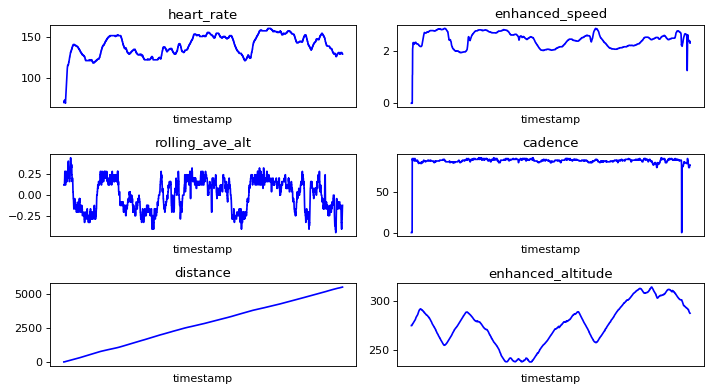

In [7]:
eda_example = pd.read_csv(fit_path+'/RUN_2021-08-26-07-15-23.fit.csv', index_col='timestamp')[eda_model_features]

def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=int(len(eda_model_features)/2+0.5), ncols=2, figsize=(9, 5), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(eda_model_features)):
        key = eda_model_features[i]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color='b',
            title="{}".format(key),
            rot=25,
        )
        ax.set_xticks([])
    plt.tight_layout()

show_raw_visualization(eda_example)
plt.savefig(graph_path+"/HR_eda.png")


## Create validation dataset

In [ ]:
# validation dataset - train each file at the time
n=0
for file in valid_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]]
    
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )
    if n==0 : dataset_val_old = dataset_val
    if n>0 : dataset_val_old = dataset_val.concatenate(dataset_val_old)
    
    n=n+1

dataset_val = dataset_val_old

# calculate stats for a naive model

In [ ]:
# Calculate statistics for the naive model
# make dataframe for the naive model
d_naive = pd.DataFrame(columns=['measured', 'predicted'])
d_naive['measured']=denormalize_hr(x[n_y:,0])
d_naive['predicted']=denormalize_hr(x[:-n_y,0])

# calculate some stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy

y_test, pred_test = d_naive['measured'].values, d_naive['predicted'].values

MSE_test=round(mean_squared_error(y_test, pred_test, squared=True),3)
MAE_test=round(mean_absolute_error(y_test, pred_test),3)

test_sdev = np.std(pred_test-y_test)*1.96
test_mean = np.mean(pred_test-y_test)


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

mean_s, ci95_l, ci95_h, mean_uncertainty = mean_confidence_interval(data=(pred_test-y_test))

print('Naive model\nMAE = '+ str(MAE_test)+", MSE = "+str(MSE_test))
print ('Mean and 95% prediction interval = {} +/- {}'.format(test_mean,test_sdev))
print('Uncertainty of mean = '+ str(mean_uncertainty))

Naive model
MAE = 4.274, MSE = 42.304
Mean and 95% prediction interval = -0.5512304250559285 +/- 12.702311586935162
Uncertainty of mean = 0.2688862263589246


## Build the model

In [ ]:
#Load the TensorBoard notebook extension
%load_ext tensorboard


# get the shapes of X & y for a batch
for batch in dataset_val.take(1):
    inputs, targets = batch

# the model architecture
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
outputs = keras.layers.LSTM(4, return_sequences=False)(inputs)
outputs = keras.layers.Dense(1)(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)

# learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=50000,
    decay_rate=0.001)

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_mae", min_delta=0, patience=5, verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/', histogram_freq=1)


modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_mae",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["mae"], loss="mae")

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 4)]          0         
                                                                 
 lstm (LSTM)                 (None, 4)                 144       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


## Load the training data, train the model

Each file is processed separately for creating the training dataset, as every file is disconnected from previous file and the moving window cannot be extendented over.

In [ ]:
# training dataset

n=0
for file in train_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    print(file)
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size
    )
    
    if n==0 : dataset_train_old = dataset_train
    if n>0 : dataset_train_old = dataset_train.concatenate(dataset_train_old)

    n=n+1

dataset_train=dataset_train_old

len(dataset_train)


C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_csv\RUN_2021-03-25-10-40-55.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_csv\RUN_2021-03-28-08-52-59.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_csv\RUN_2021-04-01-11-01-57.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_csv\RUN_2021-04-02-09-11-28.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_csv\RUN_2021-04-04-07-56-55.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_csv\RUN_2021-04-06-09-04-28.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_csv\RUN_2021-04-08-10-09-18.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_csv\RUN_2021-04-11-08-14-51.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_csv\RUN_2021-04-16-09-04-35.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_csv\RUN_2021-04-18-09-57-41.fit.csv
C:/Users/krish/Downloads/athlete_hr_pred

456

In [ ]:
# train the model, with tensorboard visualisations
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback, tensorboard_callback],
    verbose=1
)


Epoch 1/180
456/456 [==============================] - ETA: 0s - loss: 0.2914 - mae: 0.2914
Epoch 1: val_mae improved from inf to 0.30990, saving model to model_checkpoint.h5
456/456 [==============================] - 19s 37ms/step - loss: 0.2914 - mae: 0.2914 - val_loss: 0.3099 - val_mae: 0.3099
Epoch 2/180
456/456 [==============================] - ETA: 0s - loss: 0.2289 - mae: 0.2289
Epoch 2: val_mae improved from 0.30990 to 0.29656, saving model to model_checkpoint.h5
456/456 [==============================] - 16s 35ms/step - loss: 0.2289 - mae: 0.2289 - val_loss: 0.2966 - val_mae: 0.2966
Epoch 3/180
455/456 [============================>.] - ETA: 0s - loss: 0.2225 - mae: 0.2225
Epoch 3: val_mae improved from 0.29656 to 0.29182, saving model to model_checkpoint.h5
456/456 [==============================] - 16s 35ms/step - loss: 0.2225 - mae: 0.2225 - val_loss: 0.2918 - val_mae: 0.2918
Epoch 4/180
456/456 [==============================] - ETA: 0s - loss: 0.2171 - mae: 0.2171
Epoch 

In [8]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


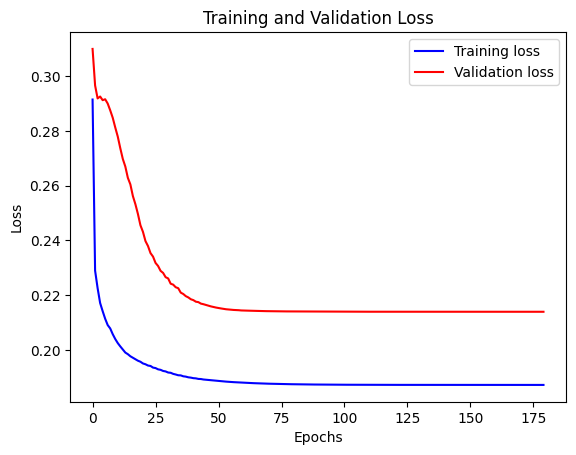

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

visualize_loss(history, "Training and Validation Loss")
plt.savefig(graph_path+'/HR_his_t'+str(n_y)+".png")


## Check the model predictions visually

In [ ]:
n=0
for file in test_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    print(file)
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    
    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=10
    )
    
    if n>0:
        dataset_test_old = dataset_train_old.concatenate(dataset_test)
    
    dataset_test_old = dataset_test
    
    n=n+1
dataset_test = dataset_test_old

C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_test_csv\RUN_2021-08-05-11-12-41.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_test_csv\RUN_2021-08-28-10-18-42.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_test_csv\RUN_2021-08-29-09-28-52.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_test_csv\RUN_2021-08-31-10-10-56.fit.csv
C:/Users/krish/Downloads/athlete_hr_predict-master/fit_file_test_csv\RUN_2021-09-01-09-09-44.fit.csv


1/1 [==============================] - 1s 582ms/step


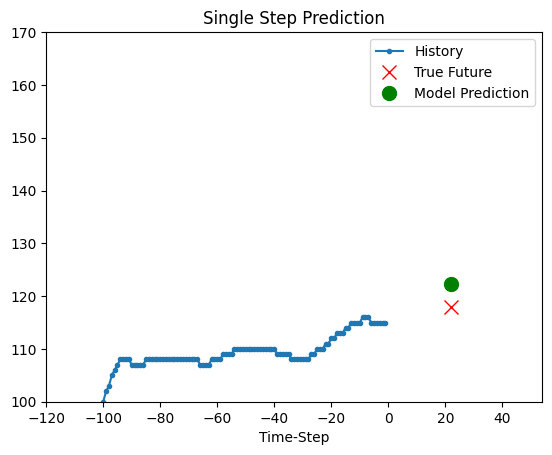

1/1 [==============================] - 0s 29ms/step


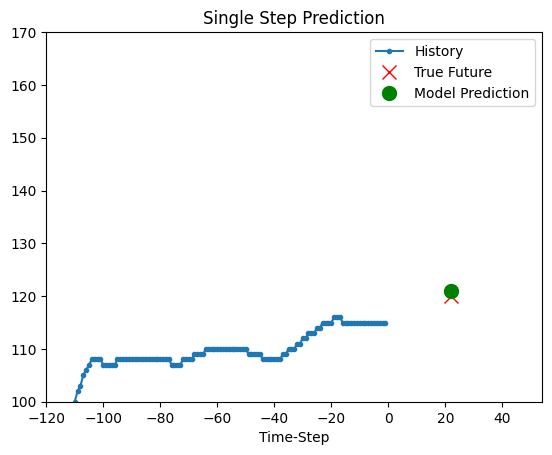

1/1 [==============================] - 0s 36ms/step


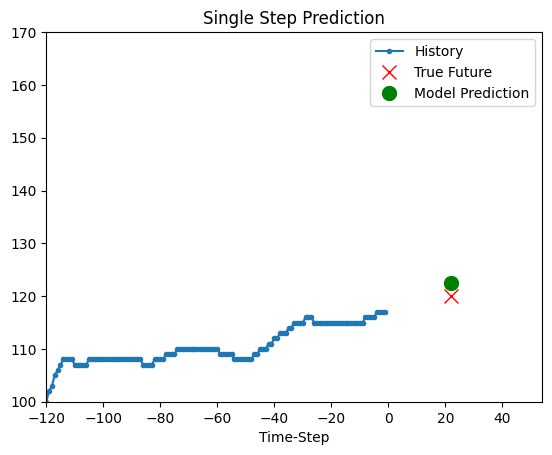

1/1 [==============================] - 0s 27ms/step


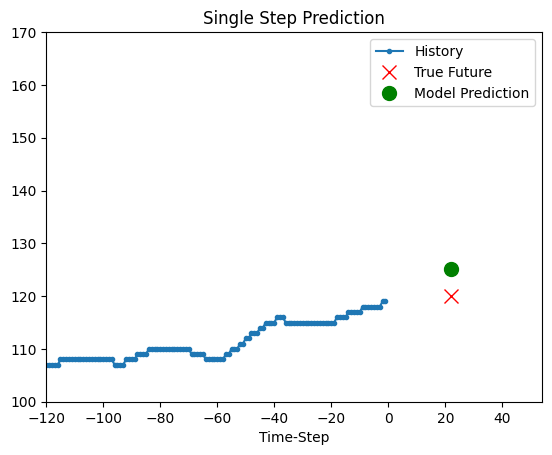

1/1 [==============================] - 0s 27ms/step


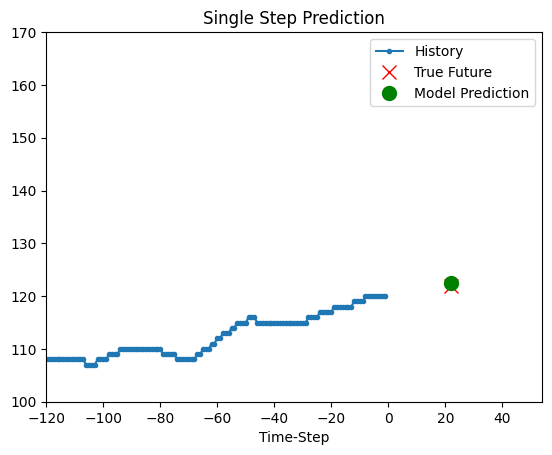

In [ ]:


def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))

    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.ylim(100,170)
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_test.take(5):
    show_plot(
        [denormalize_hr(x[0][:, 0].numpy()), denormalize_hr(y[0]), denormalize_hr( model.predict(x)[0])],
        n_y,
        "Single Step Prediction",
    )

## Model evaluation 

under construction

In [ ]:
# create a testing dataset from the kept-aside files
n=0
for file in test_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    
    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=1
    )
    
    if n==0 : dataset_test_old = dataset_test
    if n>0 : dataset_test_old = dataset_test_old.concatenate(dataset_test)
    
    n=n+1
dataset_test = dataset_test_old

# make a dataframe with predictions and observations
d=pd.DataFrame([0,1])
for x, y in dataset_test:
    a = denormalize_hr(y[0]).numpy(), denormalize_hr( model.predict(x)[0])
    c = pd.DataFrame(a).T
    d = d.merge(c, how='outer')
d.columns=['measured', 'predicted']
d = d.bfill()



1/1 [==============================] - 0s 24ms/step


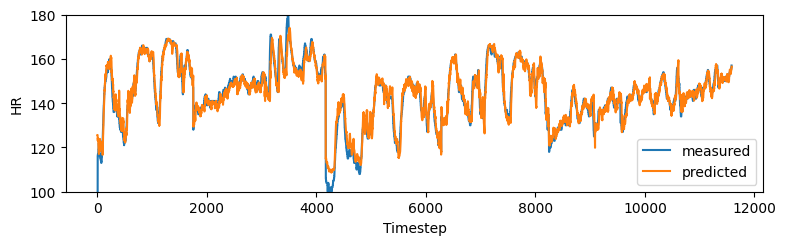

In [ ]:
                                                        # time domain plot with observed blue, and predicted orange. Predicted is calculated values where previous 30sec of inputs are missing.
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(9, 2.3)
d.plot(ylim=(100,180), xlabel='Timestep', ylabel='HR', ax=ax1)
plt.savefig(graph_path+'/HR_ex_t'+str(n_y)+".png")

In [ ]:
# calculate some stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy

y_test, pred_test = d['measured'].values,d['predicted'].values

MSE_test=round(mean_squared_error(y_test, pred_test, squared=True),3)
MAE_test=round(mean_absolute_error(y_test, pred_test),3)

test_sdev = np.std(pred_test-y_test)*1.96
test_mean = np.mean(pred_test-y_test)


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

mean_s, ci95_l, ci95_h, mean_uncertainty = mean_confidence_interval(data=(pred_test-y_test))

print('Test dataset\nMAE = '+ str(MAE_test)+", MSE = "+str(MSE_test))
print ('Mean and 95% prediction interval = {} +/- {}'.format(test_mean,test_sdev))
print('Uncertainty of mean = '+ str(mean_uncertainty))


Test dataset
MAE = 2.416, MSE = 13.799
Mean and 95% prediction interval = 0.22680651020799947 +/- 7.267358836311307
Uncertainty of mean = 0.06753396241294853


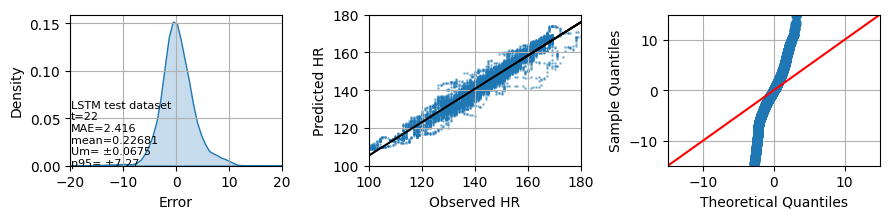

In [ ]:
# graph the model performance

import seaborn as sns
import statsmodels.api as sm

m, b = np.polyfit(y_test, pred_test, 1)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
fig.set_size_inches(9, 2.3)
sns.kdeplot( x=pred_test-y_test, fill=True, ax=ax1, common_norm=False)
ax2.scatter(x=y_test, y=pred_test, s=1, alpha=0.4)
ax2.plot(y_test, m*y_test + b, c='black')
sm.qqplot((pred_test-y_test), line ='45', ax=ax3)

ax1.set_xlim(-20,20)
ax1.set_xlabel('Error')
ax2.set_xlabel('Observed HR')
ax2.set_ylabel('Predicted HR')
ax2.set_xlim(100,180)
ax2.set_ylim(100,180)
ax3.set_xlim(-15,15)
ax3.set_ylim(-15,15)
ax1.text(-19.8,0.0,'LSTM test dataset\nt='+ str(n_y) + '\nMAE='+str(MAE_test) + "\nmean="+ str(round(mean_s,5)) + "\nUm= ±"+ str(round(mean_uncertainty,4))+'\np95= ±'+ str(round(test_sdev,2)) , fontsize=8 )
ax1.grid()
ax2.grid()
ax3.grid()
plt.tight_layout()
plt.savefig(graph_path+'/HR_t'+str(n_y)+'-'+str(n_X) +".png")


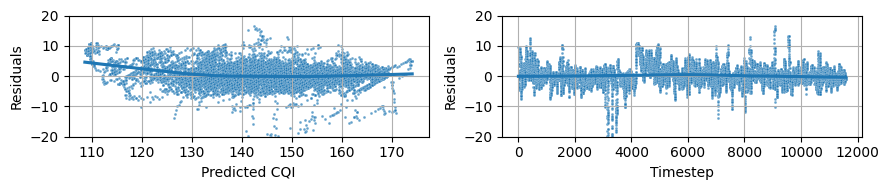

In [ ]:
# further residuals plots
fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(9, 2)

y_pred_error = (pred_test - y_test)
x_n = np.arange(0,len(y_pred_error))

sns.regplot(x=pred_test, y=y_pred_error, scatter=False,  ax=ax1, ci=95, lowess=True)
sns.regplot(x=x_n, y=y_pred_error, scatter=False,  ax=ax2, ci=95, lowess=True)
sns.scatterplot(x=pred_test, y=y_pred_error,  ax=ax1, alpha = 0.7, s=4)
sns.scatterplot(x=x_n, y=y_pred_error,  ax=ax2, alpha = 0.7, s=4)

ax2.set_ylim(-20,20)
ax1.set_ylim(-20,20)
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Residuals')
ax1.set_xlabel('Predicted CQI')
ax1.set_ylabel('Residuals')
ax1.grid()
ax2.grid()
plt.tight_layout()
plt.savefig(graph_path+'/HR_res_t'+str(n_y)+".png")